------------------------------------------------------------
KHSE winds loaded
Rows: 560034
Span: 1957-03-01 05:00:00+00:00 to 2025-08-27 02:51:00+00:00
------------------------------------------------------------
CO-OPS setup residual built
Rows: 1364334
Span: 2010-04-27 18:00:00+00:00 to 2025-12-23 16:00:00+00:00
------------------------------------------------------------
Aligned samples: 517873
Aligned span   : 2010-04-27 18:00:00+00:00 to 2025-08-27 03:00:00+00:00
Dtypes check:
Date Time    datetime64[ns, UTC]
setup_lp                 float64
U10                      float64
U2                       float64
U2_NW                    float64
dtype: object
------------------------------------------------------------
ZERO-LAG CORRELATIONS (setup_lp vs wind predictors)
setup vs U10        : r=0.015 (n=517873)
setup vs U10^2      : r=-0.028 (n=517873)
setup vs NW U10^2   : r=0.359 (n=517873)
setup vs U10^2*proj : r=0.352 (n=517873)   [axis_to=135.0°]
setup vs NW*(U10^2*proj): r=0.363 (n

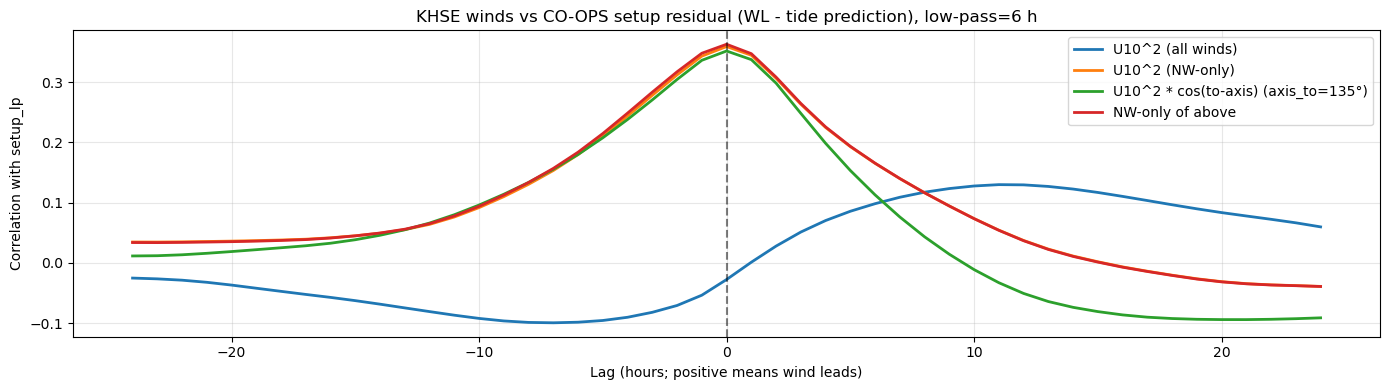

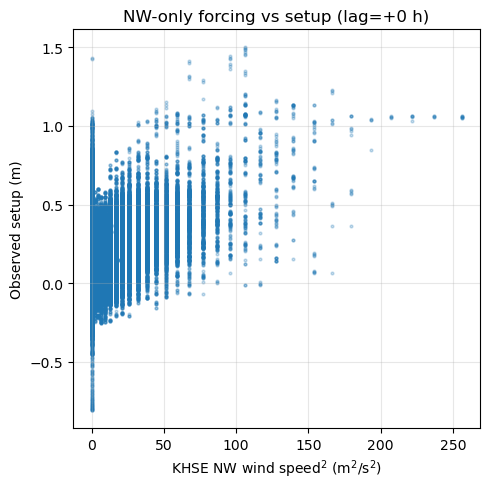

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# USER INPUTS
# ============================================================
KHSE_WIND_CSV = "isd_KHSE_only/KHSE_area_ISD_wind_merged.csv"
COOPS_WL_CSV  = "coops_8654467/COOPS_8654467_water_level_6min_MSL_metric_GMT.csv"
COOPS_PR_CSV  = "coops_8654467/COOPS_8654467_predictions_6min_MSL_metric_GMT.csv"

# Setup-analysis choices
LP_HOURS = 6                          # low-pass window for setup residual (hours)
LAG_HOURS = np.arange(-24, 25, 1)     # correlation vs lag (hours); positive means wind leads
TOL = "10min"                         # merge_asof tolerance between records
DT_MINUTES = 6                        # CO-OPS interval (min) used for LP window sizing

# NW quadrant definition (wind direction FROM, degrees)
NW_MIN, NW_MAX = 270.0, 360.0

# OPTIONAL: axis projection for directional forcing (set to None to skip)
AXIS_TO_DEG = 135.0   # direction TO that raises water at your point (deg); adjust or set None


# ============================================================
# HELPERS
# ============================================================
def is_nw(dir_from_deg):
    d = np.asarray(dir_from_deg, float) % 360.0
    return (d >= NW_MIN) & (d <= NW_MAX)

def met_from_to(dir_from_deg):
    return (np.asarray(dir_from_deg, float) + 180.0) % 360.0

def circ_diff_deg(a, b):
    return (a - b + 180.0) % 360.0 - 180.0

def corr_1d(a, b):
    """Robust correlation of two 1-D series with NaN/inf handling."""
    a = pd.to_numeric(a, errors="coerce").to_numpy()
    b = pd.to_numeric(b, errors="coerce").to_numpy()
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() < 3:
        return np.nan, int(m.sum())
    return float(np.corrcoef(a[m], b[m])[0, 1]), int(m.sum())

def lowpass_centered(series, hours, dt_minutes=6):
    """Centered moving-average low-pass (good enough for first-pass setup isolation)."""
    w = int(round((hours * 60) / dt_minutes))
    w = max(w, 3)
    return series.rolling(w, center=True, min_periods=w//2).mean()


# ============================================================
# LOAD KHSE WINDS
# ============================================================
wind = pd.read_csv(KHSE_WIND_CSV, parse_dates=["time"]).sort_values("time")
wind["time"] = pd.to_datetime(wind["time"], errors="coerce", utc=True)

wind["U10"] = pd.to_numeric(wind["wind_speed_mps"], errors="coerce")
wind["dir_from"] = pd.to_numeric(wind["wind_dir_from_deg"], errors="coerce")
wind = wind.dropna(subset=["time", "U10", "dir_from"]).reset_index(drop=True)

wind["is_NW"] = is_nw(wind["dir_from"])
wind["theta_to"] = met_from_to(wind["dir_from"])
wind["U2"] = wind["U10"]**2

# NW-only forcing (vectorized, numeric-safe)
wind["U2_NW"] = wind["U2"] * wind["is_NW"].astype(float)

# Directionally projected forcing (optional)
if AXIS_TO_DEG is not None:
    proj = np.cos(np.deg2rad(circ_diff_deg(wind["theta_to"].values, AXIS_TO_DEG)))
    wind["U2_proj"] = wind["U2"] * proj
    wind["U2_proj_NW"] = wind["U2_NW"] * proj
else:
    wind["U2_proj"] = np.nan
    wind["U2_proj_NW"] = np.nan

print("------------------------------------------------------------")
print("KHSE winds loaded")
print("Rows:", len(wind))
print("Span:", wind["time"].min(), "to", wind["time"].max())
print("------------------------------------------------------------")


# ============================================================
# LOAD CO-OPS WL + PREDICTIONS AND BUILD OBSERVED SETUP
# ============================================================
wl = pd.read_csv(COOPS_WL_CSV, parse_dates=["Date Time"])
pr = pd.read_csv(COOPS_PR_CSV, parse_dates=["Date Time"])

wl.columns = [c.strip() for c in wl.columns]
pr.columns = [c.strip() for c in pr.columns]

wl["Date Time"] = pd.to_datetime(wl["Date Time"], errors="coerce", utc=True)
pr["Date Time"] = pd.to_datetime(pr["Date Time"], errors="coerce", utc=True)

# Use expected column names (adjust if your files differ)
wl["wl_m"] = pd.to_numeric(wl["Water Level"], errors="coerce")
pr["pred_m"] = pd.to_numeric(pr["Prediction"], errors="coerce")

wl = wl.dropna(subset=["Date Time", "wl_m"]).sort_values("Date Time")
pr = pr.dropna(subset=["Date Time", "pred_m"]).sort_values("Date Time")

obs = pd.merge(wl[["Date Time", "wl_m"]], pr[["Date Time", "pred_m"]],
               on="Date Time", how="inner").sort_values("Date Time").reset_index(drop=True)

obs["setup_obs_m"] = obs["wl_m"] - obs["pred_m"]
obs["setup_lp"] = lowpass_centered(obs["setup_obs_m"], LP_HOURS, dt_minutes=DT_MINUTES)

print("CO-OPS setup residual built")
print("Rows:", len(obs))
print("Span:", obs["Date Time"].min(), "to", obs["Date Time"].max())
print("------------------------------------------------------------")


# ============================================================
# ALIGN (merge_asof) CO-OPS SETUP WITH KHSE WINDS
# ============================================================
wind2 = wind.rename(columns={"time": "Date Time"}).sort_values("Date Time")
obs2  = obs.sort_values("Date Time")

df = pd.merge_asof(
    obs2,
    wind2,
    on="Date Time",
    direction="nearest",
    tolerance=pd.Timedelta(TOL),
)

df = df.dropna(subset=["setup_lp", "U10", "dir_from"]).reset_index(drop=True)

print("Aligned samples:", len(df))
print("Aligned span   :", df["Date Time"].min(), "to", df["Date Time"].max())
print("Dtypes check:")
print(df[["Date Time", "setup_lp", "U10", "U2", "U2_NW"]].dtypes)
print("------------------------------------------------------------")


# ============================================================
# ZERO-LAG CORRELATIONS
# ============================================================
r_u10, n_u10 = corr_1d(df["setup_lp"], df["U10"])
r_u2,  n_u2  = corr_1d(df["setup_lp"], df["U2"])
r_nw,  n_nw  = corr_1d(df["setup_lp"], df["U2_NW"])

print("ZERO-LAG CORRELATIONS (setup_lp vs wind predictors)")
print(f"setup vs U10        : r={r_u10:.3f} (n={n_u10})")
print(f"setup vs U10^2      : r={r_u2:.3f} (n={n_u2})")
print(f"setup vs NW U10^2   : r={r_nw:.3f} (n={n_nw})")

if AXIS_TO_DEG is not None:
    r_proj, n_proj = corr_1d(df["setup_lp"], df["U2_proj"])
    r_proj_nw, n_proj_nw = corr_1d(df["setup_lp"], df["U2_proj_NW"])
    print(f"setup vs U10^2*proj : r={r_proj:.3f} (n={n_proj})   [axis_to={AXIS_TO_DEG:.1f}°]")
    print(f"setup vs NW*(U10^2*proj): r={r_proj_nw:.3f} (n={n_proj_nw})")
print("------------------------------------------------------------")


# ============================================================
# LAGGED CORRELATION ANALYSIS
# NOTE: shifting uses sample index; it assumes near-uniform 6-min sampling
# ============================================================
# Determine samples per hour from median dt in minutes
dt_minutes = np.nanmedian(df["Date Time"].diff().dt.total_seconds() / 60.0)
samp_per_hour = int(round(60.0 / dt_minutes)) if np.isfinite(dt_minutes) and dt_minutes > 0 else 10

corr_all = []
corr_nw  = []
corr_proj = []
corr_proj_nw = []

for lag_h in LAG_HOURS:
    lag_k = int(round(lag_h * samp_per_hour))
    x_all = df["U2"].shift(lag_k)
    x_nw  = df["U2_NW"].shift(lag_k)

    rA, _ = corr_1d(df["setup_lp"], x_all)
    rN, _ = corr_1d(df["setup_lp"], x_nw)
    corr_all.append(rA)
    corr_nw.append(rN)

    if AXIS_TO_DEG is not None:
        xP  = df["U2_proj"].shift(lag_k)
        xPN = df["U2_proj_NW"].shift(lag_k)
        rP, _  = corr_1d(df["setup_lp"], xP)
        rPN, _ = corr_1d(df["setup_lp"], xPN)
        corr_proj.append(rP)
        corr_proj_nw.append(rPN)

corr_all = np.array(corr_all, float)
corr_nw  = np.array(corr_nw, float)

best_lag_all = LAG_HOURS[np.nanargmax(corr_all)]
best_lag_nw  = LAG_HOURS[np.nanargmax(corr_nw)]
print("BEST LAGS (positive lag means wind leads setup)")
print(f"All winds: lag={best_lag_all:+.0f} h  rmax={np.nanmax(corr_all):.3f}")
print(f"NW only  : lag={best_lag_nw:+.0f} h  rmax={np.nanmax(corr_nw):.3f}")

if AXIS_TO_DEG is not None:
    corr_proj = np.array(corr_proj, float)
    corr_proj_nw = np.array(corr_proj_nw, float)
    best_lag_proj = LAG_HOURS[np.nanargmax(corr_proj)]
    best_lag_proj_nw = LAG_HOURS[np.nanargmax(corr_proj_nw)]
    print(f"Proj     : lag={best_lag_proj:+.0f} h  rmax={np.nanmax(corr_proj):.3f}   [axis_to={AXIS_TO_DEG:.1f}°]")
    print(f"Proj+NW  : lag={best_lag_proj_nw:+.0f} h  rmax={np.nanmax(corr_proj_nw):.3f}")
print("------------------------------------------------------------")


# ============================================================
# PLOTS
# ============================================================
plt.figure(figsize=(14,4))
plt.plot(LAG_HOURS, corr_all, label="U10^2 (all winds)", linewidth=2)
plt.plot(LAG_HOURS, corr_nw,  label="U10^2 (NW-only)", linewidth=2)
if AXIS_TO_DEG is not None:
    plt.plot(LAG_HOURS, corr_proj,    label=f"U10^2 * cos(to-axis) (axis_to={AXIS_TO_DEG:.0f}°)", linewidth=2)
    plt.plot(LAG_HOURS, corr_proj_nw, label="NW-only of above", linewidth=2)
plt.axvline(0, color="k", linestyle="--", alpha=0.5)
plt.xlabel("Lag (hours; positive means wind leads)")
plt.ylabel("Correlation with setup_lp")
plt.title(f"KHSE winds vs CO-OPS setup residual (WL - tide prediction), low-pass={LP_HOURS} h")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Scatter at best NW lag for U10^2 NW-only
lag_k = int(round(best_lag_nw * samp_per_hour))
x = df["U2_NW"].shift(lag_k)
y = df["setup_lp"]

plt.figure(figsize=(5,5))
plt.scatter(x, y, s=4, alpha=0.25)
plt.xlabel("KHSE NW wind speed$^2$ (m$^2$/s$^2$)")
plt.ylabel("Observed setup (m)")
plt.title(f"NW-only forcing vs setup (lag={best_lag_nw:+.0f} h)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

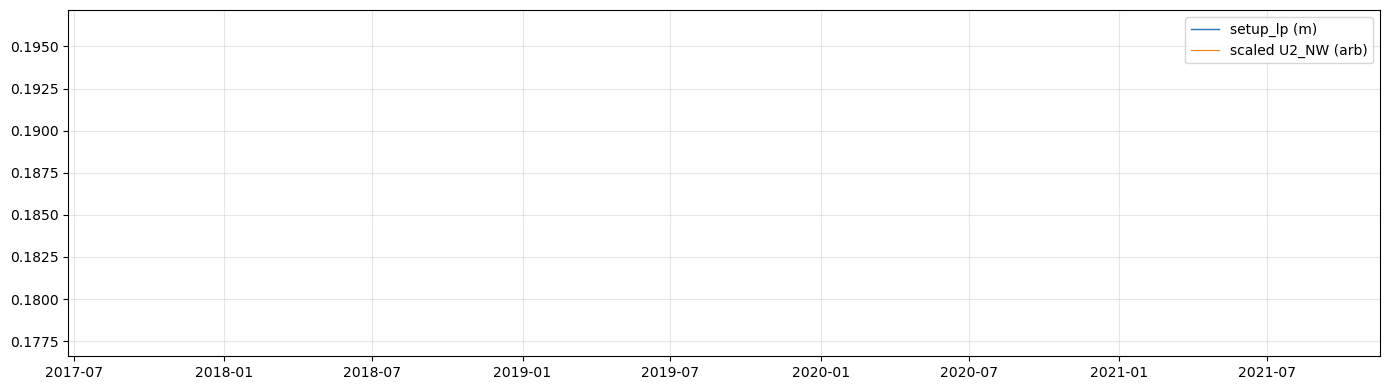

In [7]:
# Optional: quick time series overlay for a short window to eyeball lag
# (uncomment and adjust dates)

t0 = "2019-09-05"
t1 = "2019-09-05"
sub = df[(df["Date Time"] >= t0) & (df["Date Time"] <= t1)].copy()

plt.figure(figsize=(14,4))
plt.plot(sub["Date Time"], sub["setup_lp"], linewidth=1.0, label="setup_lp (m)")
plt.plot(sub["Date Time"], (sub["U2_NW"] / sub["U2_NW"].max()) * sub["setup_lp"].std(),
         linewidth=0.8, label="scaled U2_NW (arb)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

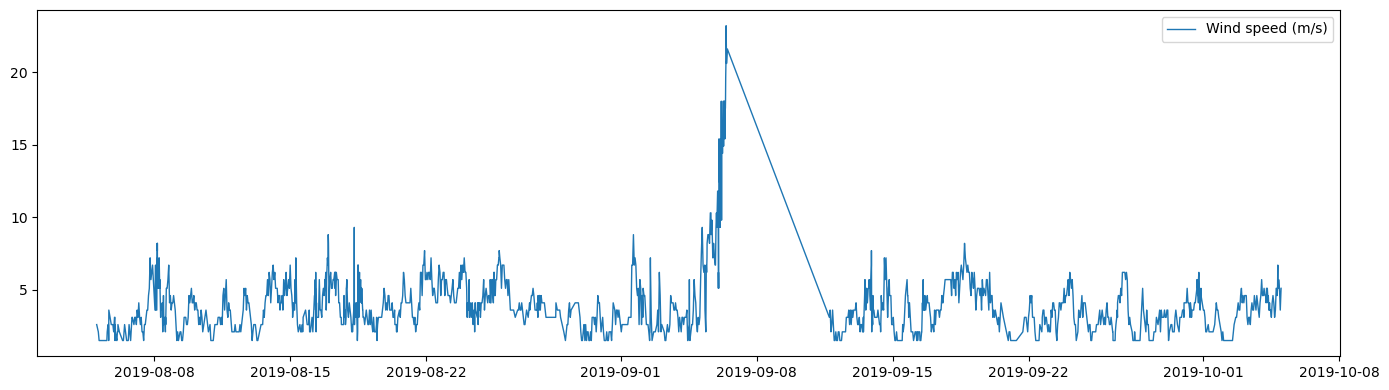

In [17]:
# Optional: quick time series overlay for a short window to eyeball lag
# (uncomment and adjust dates)

t0 = "2019-08-05"
t1 = "2019-10-05"
wind_sub = wind[(wind["time"] >= t0) & (wind["time"] <= t1)].copy()
wl_sub = wl[(wl["Date Time"] >= t0) & (wl["Date Time"] <= t1)].copy()
plt.figure(figsize=(14,4))
plt.plot(wind_sub["time"],wind_sub["wind_speed_mps"],linewidth=1.0, label="Wind speed (m/s)")

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
wind_sub

,time,wind_dir_from_deg,wind_speed_mps,usafwban,U10,dir_from,is_NW,theta_to,U2,U2_NW,U2_proj,U2_proj_NW
